# Nested sampling

Recall that we want to characterize the posterior distribution.

It would solve our problem if we could approximate it with a sum of slabs:

![Approximation with slabs](img/ns-slabs.png)


If we had the slabs heights and widths -- volumes in general --, we could integrate the posterior.

We would also know the posterior probability distributions.

So lets try to find a way to find such nested slabs. We need a way to measure a sequence of heights (likelihood) and volume.

Lets think about the volume enclosed above a likelihood threshold.

<img src="img/shells.png" alt="Likelihood shells" width="200"/>

Most of the volume will have some low likelihood, and some of it will have the highest likelihood, like so:

![Likelihood-Volume curve](img/ns-LV.png)


If we had this knowledge, we could build our slabs by dividing the volume into equal sizes, and read off the height of our slabs by the corresponding likelihood values:

![Likelihood-Volume curve](img/ns-LV-spacing.png)


Unfortunately, we do not know enough about our likelihood function to decompose the space into likelihood thresholds with equally spaced volumes. It is a really hard problem in more than one dimension.

But what if we sampled **randomly uniformly** in the volume? That would also give us likelihood thresholds:

![Likelihood-Volume curve with sampling](img/ns-LV-sampling.png)


We would get likelihoods that divide the space.

We will not know the volume sliced by the likelihood (because we do not know the yellow curve).

But order statistics tells us the distribution of the spacing. So we can estimate on average the slab volume (red). The most extreme slab is:

$\Delta V$ ~ Beta(1, N)

The height is $L$ of the sample.

Now we have a slab. Nested sampling is applying this idea repeatedly.

Lets see it in action!

## Recap

We have some target function (the likelihood times the prior) in some parameter space, and we want to integrate it.

As a toy example, we chose the following likelihood:

In [1]:
def loglikelihood(*parameters):
    a = np.asarray(parameters)[:-1] * 10
    b = np.asarray(parameters)[1:] * 10
    return -2 * (100 * (b - a**2)**2 + (1 - a)**2).sum()

And we assume our prior is uniform in the domain -1/2 to +1/2 in each parameter. 
We use two parameters at the moment.

In [2]:
lo = -0.5
hi = 0.5
dim = 2

Lets plot this function in 2d:

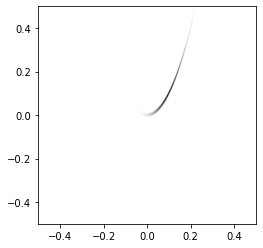

In [3]:
import numpy as np
import matplotlib.pyplot as plt

a = np.linspace(lo, hi, 400)
b = np.linspace(lo, hi, 400)

grid = np.meshgrid(a, b)
grid_unnormalised_logposterior = np.vectorize(loglikelihood)(grid[0], grid[1])

plt.imshow(
      np.exp(grid_unnormalised_logposterior[::-1]),
      extent=(lo, hi, lo, hi),
      aspect='equal', cmap='gray_r');

## Nested sampling intro

First, we parachute some walkers (called live points) into the parameter space:

In [4]:
Nlive = 40

live_points = np.random.uniform(lo, hi, size=(Nlive, dim))
live_points_loglikelihood = np.vectorize(loglikelihood)(*live_points.transpose())


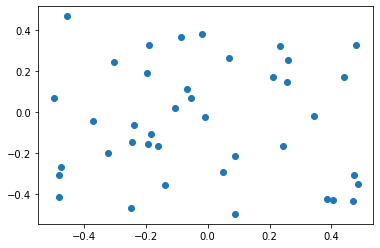

In [5]:
plt.scatter(live_points[:,0], live_points[:,1]);

![Nested sampling](img/nested-sampling.png)


They sample the entire prior volume $V=1$:

In [6]:
volume = 1

The likelihood introduces an unique ordering to these points:

In [7]:
order = np.argsort(live_points_loglikelihood)
order

array([16, 24, 23, 38, 11, 15,  7,  2, 21, 13,  6, 12, 25, 34, 18,  1,  4,
       32, 31,  3,  8, 33, 39, 35, 29, 14, 20,  5, 30, 36,  0,  9, 27, 37,
       17, 19, 22, 10, 28, 26])

* The likelihood distribution of these points follows the distribution of likelihood values of points distributed according to the prior.

* The points demarc likelihood thresholds, as visualised below. In between lies approximately similar prior volume. The fractions are distributed as $Beta(1, N_\mathrm{live})$.



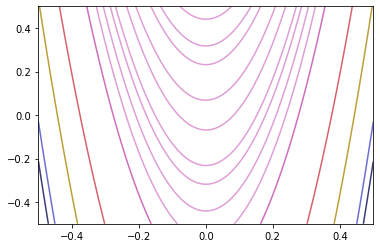

In [8]:
plt.contour(a, b, grid_unnormalised_logposterior, levels=live_points_loglikelihood[order[::4]], cmap='tab20b');

* The volumes enclosed between each likelihood interval is Beta(1, N) of the total volume. 

* But in most cases we do not have the grid above, so we do not know the exact volume. So we need to approximate it.

* Lets approximate with a random Beta(1, N) draw:

In [9]:
volume_shell = np.random.beta(1, Nlive)
volume_shell

0.01573057892187748

The volume remaining becomes smaller by this:

In [10]:
volume *= 1 - volume_shell
volume

0.9842694210781225

Lets identify the worst point (lowest likelihood contour):

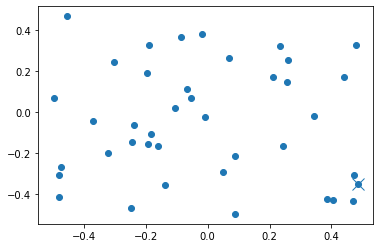

In [11]:
lowest = np.argmin(live_points_loglikelihood)
Lmin = live_points_loglikelihood[lowest]

plt.scatter(live_points[:,0], live_points[:,1])
plt.plot(live_points[lowest,0], live_points[lowest,1], 'x ', ms=12);

We kill this walker! Lets add it to the dead points:

In [12]:
dead_points = [live_points[lowest].copy()]
dead_points_loglikelihoods = [Lmin]
dead_points_volume = volume_shell


Now we have to replace the point with a new point *drawn from the prior*, 
but we only accept points whose *likelihoods is above Lmin*.

So we need a **likelihood-restricted prior sampling** method.

A simple option is to draw and throw away bad points:

In [58]:
def LRPS_rejection(Lmin):
    for i in range(10):
        proposed_points = np.random.uniform(lo, hi, size=(1000, dim))
        proposed_points_loglikelihood = np.vectorize(loglikelihood)(*proposed_points.transpose())
        if (proposed_points_loglikelihood > Lmin).any():
            i = np.where(proposed_points_loglikelihood > Lmin)[0][0]
            return proposed_points[i,:], proposed_points_loglikelihood[i]

In [59]:
live_points[lowest], live_points_loglikelihood[lowest] = LRPS_rejection(Lmin)

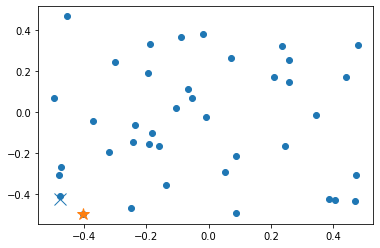

In [60]:
plt.scatter(live_points[:,0], live_points[:,1])
plt.plot(dead_points[0][0], dead_points[0][1], 'x ', ms=12);
plt.plot(live_points[lowest,0], live_points[lowest,1], '* ', ms=12);


In [61]:
def nested_sampling(Niter, Nlive):
    volume = 1
    
    live_points = np.random.uniform(lo, hi, size=(Nlive, dim))
    live_points_loglikelihood = np.vectorize(loglikelihood)(*live_points.transpose())
    
    dead_points = []
    dead_points_loglikelihoods = []
    dead_points_volume = []
    volume_remaining = []
    
    for i in range(Niter):
        # find the current likelihood threshold
        Lmin = live_points_loglikelihood.min()
        lowest = np.argmin(live_points_loglikelihood)

        # shrink volume
        volume_shell_fraction = np.random.beta(1, Nlive)
        volume_shell = volume * volume_shell_fraction
        volume *= 1 - volume_shell_fraction

        # eject this point
        dead_points.append(live_points[lowest].copy())
        dead_points_loglikelihoods.append(np.copy(Lmin))
        dead_points_volume.append(volume_shell)
        volume_remaining.append(volume)

        # replace point if we can
        replacement = LRPS_rejection(Lmin)
        if replacement is None: break
        live_points[lowest], live_points_loglikelihood[lowest] = replacement
    
    return dead_points, dead_points_loglikelihoods, dead_points_volume, volume_remaining

In [82]:
dead_points, dead_points_loglikelihoods, dead_points_volume, volume_remaining = nested_sampling(400, Nlive=40)

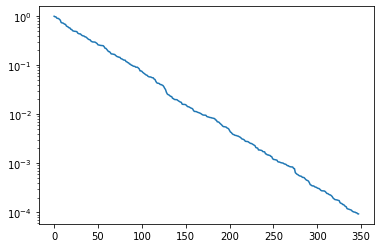

In [85]:
plt.plot(volume_remaining);
plt.yscale('log')
plt.xlabel("Iteration")
plt.ylabel("Volume")

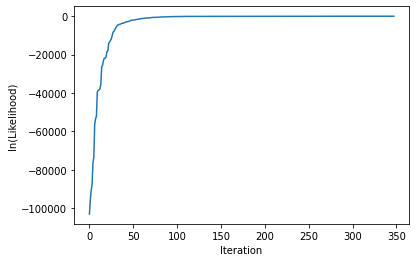

In [89]:
plt.plot(dead_points_loglikelihoods)
plt.xlabel("Iteration")
plt.ylabel("ln(Likelihood)");

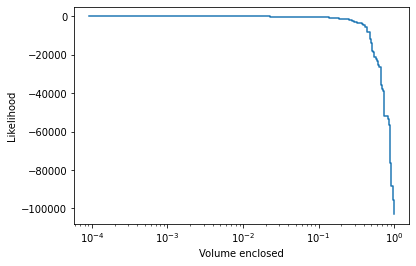

In [83]:
plt.plot(volume_remaining, dead_points_loglikelihoods, '-', drawstyle='steps-pre')
plt.xscale('log')
plt.ylabel("Likelihood")
plt.xlabel("Volume enclosed");

In [90]:
evidence = (dead_points_volume * np.exp(dead_points_loglikelihoods)).sum()

In [78]:
print("Bayesian evidence: %f" % evidence)

Bayesian evidence: 0.001182


In [84]:
dead_points_weight = dead_points_volume * np.exp(dead_points_loglikelihoods) / evidence

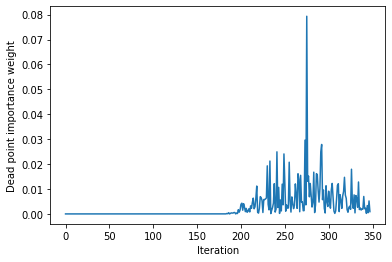

In [92]:
plt.plot(dead_points_weight)
plt.xlabel("Iteration")
plt.ylabel("Dead point importance weight");

In [93]:
def effective_sample_size(importance_weights):
    return int(len(importance_weights) / (1 + (importance_weights / importance_weights.mean() - 1)**2).mean() )

'Effective number of samples: %d' % effective_sample_size(dead_points_weight)

'Effective number of samples: 57'

In [94]:
indices_chosen = np.random.choice(len(dead_points_weight), p=dead_points_weight, size=effective_sample_size(dead_points_weight))
posterior_samples = np.asarray(dead_points)[indices_chosen]

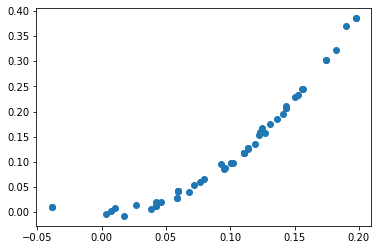

In [95]:
plt.scatter(posterior_samples[:,0], posterior_samples[:,1]);

## Exercise 1 (10 points)

Instead of terminating after Niter iterations, 
compute the largest live point evidence contribution possible: volume times highest likelihood.
Terminate when this Z_live is very small compared to the evidence summed up so far: $Z_{live} < 10^{-3} \times Z$

## Exercise 2 (30 points)

Rejection sampling is a terribly inefficient LRPS scheme. Lets replace it.

Implement MCMC as a LRPS scheme.

Hints: 

* MCMC should run on the prior as the target, not the likelihood, but:
* the Metropolis rule should accept if L>Lmin.
* Maybe the standard deviation of the live points is a good proposal size?
* Run for many iterations (1000s) before returning a new point to nested sampling.

## Homework exercise 1 (10 points)

Make several nested sampling runs.

Plot the scatter in evidence.

Plot the scatter in posterior distributions.

Reference: NESTCHECK paper

## Questions

* How does the volume decrease with iteration? Linearly, Exponentially, ...?
* What other LRPS schemes can you imagine? How would you sample a new point in the prior space under a likelihood threshold?


## Homework exercise 2 (60 points)

Set up a target likelihood which sums two Gaussians:

$f(\theta)=NormalPDF(\theta,0) + NormalPDF(\theta + \Delta, 1).$

Plot $\Delta$ vs the number of likelihood function calls needed.

For this, use the convergence from exercise 1. You can choose a LRPS scheme.